### Setup

In [1]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/MADE/Final_Project")

In [3]:
os.listdir()

['template.gslides',
 '2021_Савченко Андрей_Распознавание вовлеченности участника онлайн-мероприятия на основе анализа видеоизображений лиц.gslides',
 'data',
 'notebooks',
 'models',
 'Engagement_Labels_Engagement.xlsx']

In [4]:
import cv2
import glob

from tqdm.notebook import tqdm

from google.colab.patches import cv2_imshow

In [5]:
import pandas as pd
import numpy as np

In [6]:
import torch

from torch.utils.data import Dataset, DataLoader

### Dataset

In [7]:
train_frames_dir = "data/frames/train/"
val_frames_dir = "data/frames/validation/"

print(len(os.listdir(train_frames_dir)))
print(len(os.listdir(val_frames_dir)))

84
21


In [8]:
path_to_csv = "data/engagement_labels.csv"

In [9]:
def read_bbox_file(path):
  with open(path, "r") as f:
    bbox = f.read()
  
  return [int(b) for b in bbox.split()]

class EngagementDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.video_labels = dict(pd.read_csv(csv_file).values)
        self.root_dir = root_dir
        self.transform = transform

        self.frame_paths, self.labels = self.get_data()

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        bbox_path = frame_path.replace(".jpg", ".txt")
        label = float(self.labels[idx])

        frame_image = cv2.imread(frame_path)
        x1, y1, x2, y2 = read_bbox_file(bbox_path)

        extra_margin = 10
        face = frame_image[y1 - extra_margin :y2 + extra_margin, x1 - extra_margin:x2 + extra_margin]  # using this because original crops seem to be small
        # face = frame_image.crop((max(0, x1 - extra_margin), max(0, y1 - extra_margin),  min(frame_image.size[0], x2 + extra_margin), min(frame_image.size[1], y2 + extra_margin)))
        
        sample = {'face': face, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_data(self):
      frame_paths, labels = [], []

      for video_folder in tqdm(sorted(os.listdir(self.root_dir)), desc="Collecting paths"):
        label = self.video_labels.get(video_folder, None)
        if not label:
          continue
        float_label = float(label.replace(",", "."))

        bbox_paths = glob.glob(os.path.join(self.root_dir, video_folder, "*.txt"))
        f_paths = [p.replace(".txt", ".jpg") for p in bbox_paths]  # there are some missing bboxes, so we pick those with bboxes

        frame_paths += f_paths
        labels += [float_label] * len(f_paths)
      
      assert len(frame_paths) == len(labels)
      
      return frame_paths, labels

In [10]:
def read_bbox_file(path):
    with open(path, "r") as f:
        bbox = f.read()
  
    return [int(b) for b in bbox.split()]

class EngagementDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform, bb_path):
        self.video_labels = dict(pd.read_csv(csv_file).values)
        self.root_dir = root_dir
        self.transform = transform

        self.frame_paths, self.labels = self.get_data()
        # self.bboxes = [read_bbox_file(self.frame_paths[0].replace('.jpg', '.txt'))]
        if bb_path is not None:
            self.bboxes = pickle.load(open(bb_path, 'rb'))

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        try:
            frame_path = self.frame_paths[idx]
            label = float(self.labels[idx])

            frame_image = Image.open(frame_path)
            
            if self.bboxes is not None:
                x1, y1, x2, y2 = self.bboxes[idx]
            else:
                bbox_path = frame_path.replace(".jpg", ".txt")
                x1, y1, x2, y2 = read_bbox_file(bbox_path) #self.bboxes[idx]

            extra_margin = 10
            face = frame_image.crop((max(0, x1 - extra_margin), max(0, y1 - extra_margin),  min(frame_image.size[0], x2 + extra_margin), min(frame_image.size[1], y2 + extra_margin)))
            # face = frame_image[max(0, y1 - extra_margin):y2 + extra_margin, max(0, x1 - extra_margin):x2 + extra_margin]  # using this because original crops seem to be small
            
            sample = {'face': face, 'label': label}
            if self.transform:
                sample = self.transform(sample)

            return sample
        except:
            return(self.__getitem__(0))

    def get_data(self):
        frame_paths, labels, bboxes = [], [], []

        for video_folder in tqdm(sorted(os.listdir(self.root_dir)), desc="Collecting paths"):
            label = self.video_labels.get(video_folder, None)
            if not label:
                continue
            float_label = float(label.replace(",", "."))

            bbox_paths = glob.glob(os.path.join(self.root_dir, video_folder, "*.txt"))
            f_paths = [p.replace(".txt", ".jpg") for p in bbox_paths]  # there are some missing bboxes, so we pick those with bboxes

            frame_paths += f_paths
            labels += [float_label] * len(f_paths)
            # bboxes += [read_bbox_file(bbox_path) for bbox_path in bbox_paths]

        assert len(frame_paths) == len(labels)

        return frame_paths, labels #, bboxes

In [11]:
from torchvision import transforms
resize = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((112,112)),
    transforms.ToTensor()
])

def preprocess(sample, transform=resize):
    
    sample['face'] = transform(sample['face'])
    return sample

In [12]:
train_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=train_frames_dir, transform=preprocess, bb_path=None)

In [13]:
len(train_dataset)

51436

In [ ]:
sample = train_dataset[0]
cv2_imshow(sample["face"])
print(sample["label"])

In [ ]:
val_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=val_frames_dir)

In [ ]:
len(val_dataset)

18791

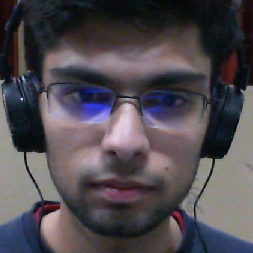

1.0


In [ ]:
sample = val_dataset[0]
cv2_imshow(sample["face"])
print(sample["label"])

In [16]:
batch_size = 256 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
import time

count = 0

for batch in tqdm(train_dataloader):

  start = time.time()
  x = batch['face'].cuda()
  labels = batch['label'].cuda()

  print(time.time() - start)

  count += 1
  if count == 10:
    break

  0%|          | 0/201 [00:00<?, ?it/s]

RuntimeError: ignored

### Model